In [25]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats.mstats import mquantiles
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
df = pd.read_excel('/Users/lucasginevro/Downloads/data_set_hackathon.xlsx')

In [27]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


array([[<Axes: title={'center': 'Customer Order Code'}>,
        <Axes: title={'center': 'value'}>]], dtype=object)

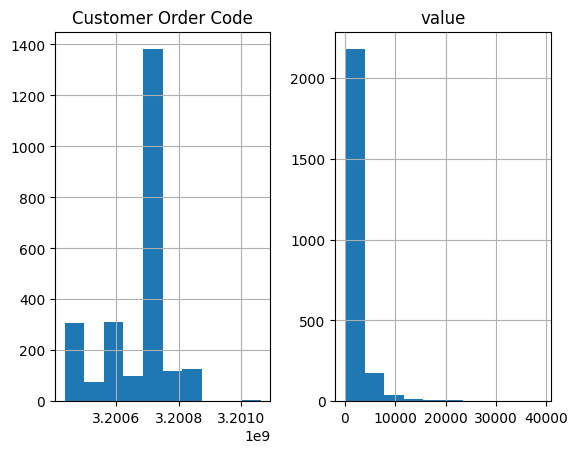

In [29]:
df.hist()

In [30]:
df.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


# Monthly Distinct Orders

In [31]:
# Handle missing values
# Check for presence of 'Items' column and handle missing data
df['Items'] = df['Items'].fillna(0) if 'Items' in df.columns else 0
df = df.dropna(subset=['order_date', 'requested_delivery_date', 'Customer Order Code'])

# Convert 'order_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Extract year and month
df['Year-Month'] = df['order_date'].dt.to_period('M')

# Filter data to only include years 2009-2011
df = df[(df['order_date'].dt.year >= 2009) & (df['order_date'].dt.year <= 2011)]

# Group by 'Year-Month' and count distinct 'Customer Order Code'
monthly_distinct_orders = (
    df.groupby('Year-Month')['Customer Order Code']
    .nunique()
    .reset_index(name='Distinct Orders')
)

print(monthly_distinct_orders)

   Year-Month  Distinct Orders
0     2009-07               38
1     2009-08                9
2     2009-09               12
3     2009-10                4
4     2009-11                2
5     2009-12               21
6     2010-01               29
7     2010-02               36
8     2010-03               43
9     2010-04               11
10    2010-05                1
11    2010-06                1
12    2010-12               34
13    2011-01              124
14    2011-02               53
15    2011-03               29
16    2011-04                6
17    2011-05                4
18    2011-06                6
19    2011-07              238
20    2011-08              186
21    2011-09               89
22    2011-10               13
23    2011-11                3


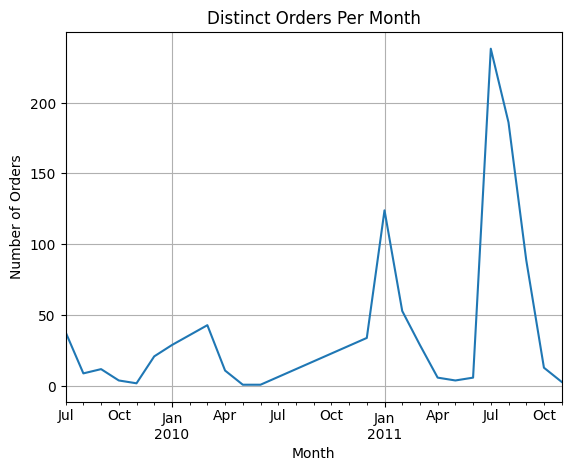

In [32]:
# Create 'Month' column for grouping
df['Month'] = df['order_date'].dt.to_period('M')

# 1. Forecast number of distinct orders per month
distinct_orders = df.groupby('Month')['Customer Order Code'].nunique()

# Plot the number of distinct orders per month
distinct_orders.plot(kind='line', title='Distinct Orders Per Month', ylabel='Number of Orders', xlabel='Month')
plt.grid()
plt.show()

# Which Items are Demanded?

In [33]:
# STEP 1: Mark Urgent Orders
df['urgent_flag'] = np.where(df['requested_delivery_date'] < df['order_date'], 1, 0)

In [34]:
# STEP 2: Aggregate to monthly
# Convert 'Month' column (Period type) to a datetime index if necessary
df['Month'] = df['order_date'].dt.to_period('M').dt.to_timestamp('M')  # End-of-month timestamp
monthly_distinct_orders = df.groupby('Month')['Customer Order Code'].nunique().to_frame('distinct_orders')

In [35]:
# Extract the month and map to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['season'] = df['order_date'].dt.month.apply(get_season)

# Perform one-hot encoding for the season column
df = pd.get_dummies(df, columns=['season'], prefix='season')

# Check the updated dataset
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route,Items,Year-Month,Month,urgent_flag,season_Fall,season_Spring,season_Summer,season_Winter
0,2009-07-13,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001,0,2009-07,2009-07-31,0,False,False,True,False
1,2009-07-15,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001,0,2009-07,2009-07-31,0,False,False,True,False
2,2009-07-16,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001,0,2009-07,2009-07-31,0,False,False,True,False
3,2009-07-17,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001,0,2009-07,2009-07-31,0,False,False,True,False
4,2009-07-21,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001,0,2009-07,2009-07-31,0,False,False,True,False


In [41]:
# Ensure 'items' and 'value' are numeric
df['items'] = pd.to_numeric(df['items'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Drop rows with NaN values in 'items' or 'value'
df = df.dropna(subset=['items', 'value'])

# Aggregate demand and seasonal influence by Product Code
demand_agg = df.groupby('Product Code').agg({
    'items': 'sum',  # Total items sold for demand
    'value': 'sum',  # Total revenue generated
    'season_Winter': 'sum',
    'season_Spring': 'sum',
    'season_Summer': 'sum',
    'season_Fall': 'sum'
}).reset_index()

# Convert 'items' to numeric for aggregation
demand_agg['items'] = pd.to_numeric(demand_agg['items'], errors='coerce')

# Determine high-demand products based on median items
median_demand = demand_agg['items'].median()
demand_agg['high_demand'] = (demand_agg['items'] > median_demand).astype(int)  # Binary classification

# Display the top products by demand
demand_agg_sorted = demand_agg.sort_values(by='items', ascending=False)

# Sort the aggregated data by total demand
demand_agg_sorted = demand_agg.sort_values(by='items', ascending=False)

# Display the cleaned and sorted demand data
print(demand_agg_sorted)


   Product Code   items      value  season_Winter  season_Spring  \
31    L12918400  1086.0  294505.42              0              0   
39    L12919200  1074.0   79129.96              0              0   
19    L12135800  1064.0   32343.28            117              9   
29    L12917900  1037.0  124856.47              0              0   
30    L12918000   849.0   15765.93              0              0   
34    L12918700   805.0  190808.19              0              0   
15    L12134400   787.0  238207.37             53             16   
24    L12916900   783.0   30611.99              0              0   
32    L12918500   702.0  191730.64              0              0   
28    L12917800   685.0  153821.40              0              0   
37    L12919000   662.0   69147.19              0              0   
17    L12134600   652.0   91255.55             32             11   
22    L12136100   615.0   45367.02             88              2   
8     L10850600   543.0   99622.78             4

/var/folders/x3/4t6wq2jj56z96y6l3_b9mm0r0000gn/T/ipykernel_98784/3497398632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['items'] = pd.to_numeric(df['items'], errors='coerce')
/var/folders/x3/4t6wq2jj56z96y6l3_b9mm0r0000gn/T/ipykernel_98784/3497398632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = pd.to_numeric(df['value'], errors='coerce')
